# Fifth exercise (Chapter 7)¶

Chapter 7 is about regularization, in this assignment we will implement various forms of regularization for MLP's. 

* L2 regularization
* Dropout
* Early stopping

In the following code block, all necessary imports are provided as well as the data generators. You can use your MLP implementation from the previous assignment or the reference implementation attached. In this reference implementations, there are some slight differences with the network that was provided for the previous example, most notably: 

* The cost function now also has an update function integrated
* The data format is standardized for all sets (train, test and validation)

## Data

We will make use of the digits dataset, standard packed in sklearn. It contains a similar classification task as MNIST, however the images are smaller (64 pixels), making experimenting with it faster. 

For your convenience, a convert function has been provided to convert the dataset into the format that the reference network accepts. 

In [3]:
import numpy as np
import scipy.stats
import random
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

In [4]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

X, y = load_digits(return_X_y=True)
testsize = len(X) / 10
validsize = len(X) / 10

train_indices = np.arange(len(X) - testsize - validsize, dtype=np.int)
valid_indices = np.arange(len(train_indices), len(X) - testsize, dtype=np.int)
test_indices = np.arange(len(train_indices) + len(valid_indices), len(X), dtype=np.int)

train_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in train_indices]
valid_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in valid_indices]
test_set  = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in test_indices]

num_features = len(X[0])
num_classes = 10

## Reference Network

Replace the cell below with your own network from exercise 6. Make sure that it doesn't deviate to much from the reference implementation.

In [5]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


class QuadraticCost(object):
    @staticmethod
    def fn(a, y, weights):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        
        a is an array (size (num_classes, 1)) the activations of the output_layer,
        y is an array (same size) with the class label.
        """
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).
           
           z, a and y are arrays of shape (num_classes, 1)
        """
        return (a - y) * sigmoid_prime(z)

    @staticmethod
    def update(w, nw, eta, size):
        """Does a single gradient step. 
        
        w and nw are arrays with size corresponding to the weights vector; 
        eta and size are scalars. 
        """
        return w - (eta / size) * nw


class Network(object):
    def __init__(self, sizes, cost=QuadraticCost):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost

    def feedforward(self, a, masks=None):
        """Return the output of the network if ``a`` is input."""
        if masks is None:
            masks = [1 for _ in len(self.weights)]
        for b, w, m in zip(self.biases, self.weights, masks):
            a = sigmoid(np.dot(w, a) + b) * m
        return a
    
    def SGD_stopping_steps(self, training_data, epochs, mini_batch_size, eta, patience, **args):
        i = 0
        stopping_steps = 0
        j = 0
        min_eval_accurary = float("-inf")
        train_accuracies = []
        eval_accuracies = []
        while j < patience:
            _, training_accuracy, _, evaluation_accuracy = self.SGD(training_data,
                                                    epochs, 
                                                    mini_batch_size, 
                                                    eta,
                                                    monitor_training_accuracy=True,
                                                    monitor_evaluation_accuracy=True,
                                                    **args)
            i += epochs
            train_accuracies += training_accuracy
            eval_accuracies += evaluation_accuracy
            if evaluation_accuracy[-1] > min_eval_accurary:
                min_eval_accurary = evaluation_accuracy[-1]
                stopping_steps = i
                j = 0
            else:
                j += 1
                
        return stopping_steps, train_accuracies, eval_accuracies
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            p_input=1, p_hidden=1, k=1,
            validation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs. Here, x represents an array with dimensions 
        (num_attributes, 1); y is an array of size (num_classes, 1) 
        The other non-optional parameters are self-explanatory.  
        If ``test_data`` is provided (same format as training_data) 
        then the network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        if validation_data: n_data = len(validation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta,
                                       p_input, p_hidden)

            print("Epoch {0} complete".format(j))

            if monitor_training_cost:
                cost = self.total_cost(training_data, k, p_input, p_hidden)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, k, p_input, p_hidden)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(validation_data, k, p_input, p_hidden)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(validation_data, k, p_input, p_hidden)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(validation_data, k, p_input, p_hidden), n_data))
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy

    def update_mini_batch(self, mini_batch, eta, p_input, p_hidden):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)`` (similar to 
        the data structure defined in SGD) and ``eta`` is the learning 
        rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y, p_input, p_hidden)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [self.cost.update(w, nw, eta, len(mini_batch)) for w, nw in zip(self.weights, nabla_w)]
        self.biases = [self.cost.update(b, nb, eta, len(mini_batch)) for b, nb in zip(self.biases, nabla_b)]
        print("backprop: updating weights: norm of W_1: {}".format(np.linalg.norm(self.weights[1])))
        
        
    def backprop(self, x, y, p_input, p_hidden):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        masks = self.generate_mask(p_input, p_hidden)
        # feedforward
        activation = x
        activations = [x]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer
        for b, w, m in zip(self.biases, self.weights, masks):
            z = (np.dot(w, activation) + b) * m
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost.delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            m = masks[-l]
            sp = sigmoid_prime(z)
            delta = m * np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, k, p_input, p_hidden):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.
        """
        results = [(np.argmax(self.inference(x, k, p_input, p_hidden)), 
                    np.argmax(y)) for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, k, p_input, p_hidden):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.inference(x, k, p_input, p_hidden)
            cost += self.cost.fn(a, y, self.weights) / len(data)
        return cost
    
    def generate_mask(self, p_input, p_hidden):
        """ Generate binary masks for dropout.
            Last mask contains only ones.
        
            p_input (float): probability for a one in first array
            p_hidden (float): probability for a one in between arrays
            
            Return: list of random binary arrays with layer size
        """
        masks = []
        first_mask = scipy.stats.bernoulli.rvs(p_input, 
                                               size=(self.sizes[1], 1))
        masks.append(first_mask)
        for layer_size in self.sizes[2:-1]:
            hidden_mask = scipy.stats.bernoulli.rvs(p_hidden,
                                                    size=(layer_size, 1))
            masks.append(hidden_mask)
        last_mask = np.ones((self.sizes[-1], 1))
        masks.append(last_mask)
        return masks
    
    def inference(self, x, k, p_input, p_hidden):
        a = 0
        for i in range(k):
            masks = self.generate_mask(p_input, p_hidden)
            a = a + self.feedforward(x, masks)
        return a / k

## L2 Regularization

Implement L2 regularization using the equations 7.1 - 7.5, by creating a new cost class (containing hyperparameter alpha), containing the same functions as QuadraticCost, i.e., fn, delta and update. Plot how test performance varies for various values of alpha. 

In [6]:
class L2QuadraticCost(object):
    def __init__(self, alpha):
        self.alpha = alpha
        
    def fn(self, a, y, weights):
        weight_norm = np.mean([np.linalg.norm(w)**2 for w in weights])
        base_fn = QuadraticCost.fn(a, y, w)
        return self.alpha / 2 * weight_norm + base_fn

    def delta(self, z, a, y):
        return QuadraticCost.delta(z, a, y)
    
    def update(self, w, nw, eta, size):
        return (1 - eta * self.alpha) * w - (eta / size) * nw
            
    

In [227]:
layers = [num_features, 50, 50, 50, num_classes]

def l2_test_accuracy(alpha):
    cost = L2QuadraticCost(alpha)
    net = Network(layers, cost)
    sgd_result = net.SGD(train_set, 300,
                         50, 0.1, k=2,
                         validation_data=test_set,
                         monitor_evaluation_accuracy=True)
    t_cost, t_accuracy, e_cost, e_accuracy = sgd_result
    return np.array(e_accuracy) / len(test_set)

alphas = (0, 0.0001, 0.001, 0.01, 0.1)
l2_accuracies = [l2_test_accuracy(a) for a in alphas]

Epoch 0 complete
Accuracy on evaluation data: 30 / 179
Epoch 1 complete
Accuracy on evaluation data: 33 / 179
Epoch 2 complete
Accuracy on evaluation data: 36 / 179
Epoch 3 complete
Accuracy on evaluation data: 40 / 179
Epoch 4 complete
Accuracy on evaluation data: 42 / 179
Epoch 5 complete
Accuracy on evaluation data: 44 / 179
Epoch 6 complete
Accuracy on evaluation data: 47 / 179
Epoch 7 complete
Accuracy on evaluation data: 51 / 179
Epoch 8 complete
Accuracy on evaluation data: 53 / 179
Epoch 9 complete
Accuracy on evaluation data: 54 / 179
Epoch 10 complete
Accuracy on evaluation data: 54 / 179
Epoch 11 complete
Accuracy on evaluation data: 57 / 179
Epoch 12 complete
Accuracy on evaluation data: 57 / 179
Epoch 13 complete
Accuracy on evaluation data: 59 / 179
Epoch 14 complete
Accuracy on evaluation data: 59 / 179
Epoch 15 complete
Accuracy on evaluation data: 59 / 179
Epoch 16 complete
Accuracy on evaluation data: 61 / 179
Epoch 17 complete
Accuracy on evaluation data: 63 / 179
Ep

Epoch 144 complete
Accuracy on evaluation data: 125 / 179
Epoch 145 complete
Accuracy on evaluation data: 125 / 179
Epoch 146 complete
Accuracy on evaluation data: 125 / 179
Epoch 147 complete
Accuracy on evaluation data: 125 / 179
Epoch 148 complete
Accuracy on evaluation data: 125 / 179
Epoch 149 complete
Accuracy on evaluation data: 125 / 179
Epoch 150 complete
Accuracy on evaluation data: 125 / 179
Epoch 151 complete
Accuracy on evaluation data: 125 / 179
Epoch 152 complete
Accuracy on evaluation data: 125 / 179
Epoch 153 complete
Accuracy on evaluation data: 125 / 179
Epoch 154 complete
Accuracy on evaluation data: 125 / 179
Epoch 155 complete
Accuracy on evaluation data: 125 / 179
Epoch 156 complete
Accuracy on evaluation data: 125 / 179
Epoch 157 complete
Accuracy on evaluation data: 125 / 179
Epoch 158 complete
Accuracy on evaluation data: 125 / 179
Epoch 159 complete
Accuracy on evaluation data: 125 / 179
Epoch 160 complete
Accuracy on evaluation data: 125 / 179
Epoch 161 comp

Epoch 286 complete
Accuracy on evaluation data: 128 / 179
Epoch 287 complete
Accuracy on evaluation data: 128 / 179
Epoch 288 complete
Accuracy on evaluation data: 128 / 179
Epoch 289 complete
Accuracy on evaluation data: 128 / 179
Epoch 290 complete
Accuracy on evaluation data: 128 / 179
Epoch 291 complete
Accuracy on evaluation data: 128 / 179
Epoch 292 complete
Accuracy on evaluation data: 128 / 179
Epoch 293 complete
Accuracy on evaluation data: 128 / 179
Epoch 294 complete
Accuracy on evaluation data: 128 / 179
Epoch 295 complete
Accuracy on evaluation data: 128 / 179
Epoch 296 complete
Accuracy on evaluation data: 128 / 179
Epoch 297 complete
Accuracy on evaluation data: 128 / 179
Epoch 298 complete
Accuracy on evaluation data: 128 / 179
Epoch 299 complete
Accuracy on evaluation data: 128 / 179
Epoch 0 complete
Accuracy on evaluation data: 20 / 179
Epoch 1 complete
Accuracy on evaluation data: 16 / 179
Epoch 2 complete
Accuracy on evaluation data: 16 / 179
Epoch 3 complete
Accura

Epoch 131 complete
Accuracy on evaluation data: 136 / 179
Epoch 132 complete
Accuracy on evaluation data: 135 / 179
Epoch 133 complete
Accuracy on evaluation data: 136 / 179
Epoch 134 complete
Accuracy on evaluation data: 136 / 179
Epoch 135 complete
Accuracy on evaluation data: 136 / 179
Epoch 136 complete
Accuracy on evaluation data: 136 / 179
Epoch 137 complete
Accuracy on evaluation data: 137 / 179
Epoch 138 complete
Accuracy on evaluation data: 138 / 179
Epoch 139 complete
Accuracy on evaluation data: 138 / 179
Epoch 140 complete
Accuracy on evaluation data: 138 / 179
Epoch 141 complete
Accuracy on evaluation data: 141 / 179
Epoch 142 complete
Accuracy on evaluation data: 141 / 179
Epoch 143 complete
Accuracy on evaluation data: 140 / 179
Epoch 144 complete
Accuracy on evaluation data: 142 / 179
Epoch 145 complete
Accuracy on evaluation data: 141 / 179
Epoch 146 complete
Accuracy on evaluation data: 141 / 179
Epoch 147 complete
Accuracy on evaluation data: 141 / 179
Epoch 148 comp

Epoch 273 complete
Accuracy on evaluation data: 151 / 179
Epoch 274 complete
Accuracy on evaluation data: 151 / 179
Epoch 275 complete
Accuracy on evaluation data: 151 / 179
Epoch 276 complete
Accuracy on evaluation data: 151 / 179
Epoch 277 complete
Accuracy on evaluation data: 151 / 179
Epoch 278 complete
Accuracy on evaluation data: 151 / 179
Epoch 279 complete
Accuracy on evaluation data: 151 / 179
Epoch 280 complete
Accuracy on evaluation data: 150 / 179
Epoch 281 complete
Accuracy on evaluation data: 151 / 179
Epoch 282 complete
Accuracy on evaluation data: 151 / 179
Epoch 283 complete
Accuracy on evaluation data: 150 / 179
Epoch 284 complete
Accuracy on evaluation data: 151 / 179
Epoch 285 complete
Accuracy on evaluation data: 152 / 179
Epoch 286 complete
Accuracy on evaluation data: 151 / 179
Epoch 287 complete
Accuracy on evaluation data: 150 / 179
Epoch 288 complete
Accuracy on evaluation data: 152 / 179
Epoch 289 complete
Accuracy on evaluation data: 151 / 179
Epoch 290 comp

Epoch 117 complete
Accuracy on evaluation data: 132 / 179
Epoch 118 complete
Accuracy on evaluation data: 135 / 179
Epoch 119 complete
Accuracy on evaluation data: 135 / 179
Epoch 120 complete
Accuracy on evaluation data: 134 / 179
Epoch 121 complete
Accuracy on evaluation data: 135 / 179
Epoch 122 complete
Accuracy on evaluation data: 135 / 179
Epoch 123 complete
Accuracy on evaluation data: 135 / 179
Epoch 124 complete
Accuracy on evaluation data: 136 / 179
Epoch 125 complete
Accuracy on evaluation data: 137 / 179
Epoch 126 complete
Accuracy on evaluation data: 138 / 179
Epoch 127 complete
Accuracy on evaluation data: 139 / 179
Epoch 128 complete
Accuracy on evaluation data: 139 / 179
Epoch 129 complete
Accuracy on evaluation data: 139 / 179
Epoch 130 complete
Accuracy on evaluation data: 139 / 179
Epoch 131 complete
Accuracy on evaluation data: 139 / 179
Epoch 132 complete
Accuracy on evaluation data: 139 / 179
Epoch 133 complete
Accuracy on evaluation data: 139 / 179
Epoch 134 comp

Epoch 259 complete
Accuracy on evaluation data: 161 / 179
Epoch 260 complete
Accuracy on evaluation data: 161 / 179
Epoch 261 complete
Accuracy on evaluation data: 161 / 179
Epoch 262 complete
Accuracy on evaluation data: 161 / 179
Epoch 263 complete
Accuracy on evaluation data: 161 / 179
Epoch 264 complete
Accuracy on evaluation data: 161 / 179
Epoch 265 complete
Accuracy on evaluation data: 161 / 179
Epoch 266 complete
Accuracy on evaluation data: 161 / 179
Epoch 267 complete
Accuracy on evaluation data: 161 / 179
Epoch 268 complete
Accuracy on evaluation data: 161 / 179
Epoch 269 complete
Accuracy on evaluation data: 161 / 179
Epoch 270 complete
Accuracy on evaluation data: 161 / 179
Epoch 271 complete
Accuracy on evaluation data: 161 / 179
Epoch 272 complete
Accuracy on evaluation data: 161 / 179
Epoch 273 complete
Accuracy on evaluation data: 160 / 179
Epoch 274 complete
Accuracy on evaluation data: 160 / 179
Epoch 275 complete
Accuracy on evaluation data: 160 / 179
Epoch 276 comp

Epoch 104 complete
Accuracy on evaluation data: 50 / 179
Epoch 105 complete
Accuracy on evaluation data: 53 / 179
Epoch 106 complete
Accuracy on evaluation data: 46 / 179
Epoch 107 complete
Accuracy on evaluation data: 36 / 179
Epoch 108 complete
Accuracy on evaluation data: 26 / 179
Epoch 109 complete
Accuracy on evaluation data: 25 / 179
Epoch 110 complete
Accuracy on evaluation data: 19 / 179
Epoch 111 complete
Accuracy on evaluation data: 34 / 179
Epoch 112 complete
Accuracy on evaluation data: 47 / 179
Epoch 113 complete
Accuracy on evaluation data: 35 / 179
Epoch 114 complete
Accuracy on evaluation data: 31 / 179
Epoch 115 complete
Accuracy on evaluation data: 35 / 179
Epoch 116 complete
Accuracy on evaluation data: 19 / 179
Epoch 117 complete
Accuracy on evaluation data: 19 / 179
Epoch 118 complete
Accuracy on evaluation data: 19 / 179
Epoch 119 complete
Accuracy on evaluation data: 19 / 179
Epoch 120 complete
Accuracy on evaluation data: 19 / 179
Epoch 121 complete
Accuracy on 

Epoch 248 complete
Accuracy on evaluation data: 18 / 179
Epoch 249 complete
Accuracy on evaluation data: 18 / 179
Epoch 250 complete
Accuracy on evaluation data: 18 / 179
Epoch 251 complete
Accuracy on evaluation data: 18 / 179
Epoch 252 complete
Accuracy on evaluation data: 19 / 179
Epoch 253 complete
Accuracy on evaluation data: 17 / 179
Epoch 254 complete
Accuracy on evaluation data: 18 / 179
Epoch 255 complete
Accuracy on evaluation data: 19 / 179
Epoch 256 complete
Accuracy on evaluation data: 18 / 179
Epoch 257 complete
Accuracy on evaluation data: 18 / 179
Epoch 258 complete
Accuracy on evaluation data: 17 / 179
Epoch 259 complete
Accuracy on evaluation data: 18 / 179
Epoch 260 complete
Accuracy on evaluation data: 18 / 179
Epoch 261 complete
Accuracy on evaluation data: 18 / 179
Epoch 262 complete
Accuracy on evaluation data: 18 / 179
Epoch 263 complete
Accuracy on evaluation data: 17 / 179
Epoch 264 complete
Accuracy on evaluation data: 19 / 179
Epoch 265 complete
Accuracy on 

Epoch 94 complete
Accuracy on evaluation data: 19 / 179
Epoch 95 complete
Accuracy on evaluation data: 17 / 179
Epoch 96 complete
Accuracy on evaluation data: 19 / 179
Epoch 97 complete
Accuracy on evaluation data: 19 / 179
Epoch 98 complete
Accuracy on evaluation data: 16 / 179
Epoch 99 complete
Accuracy on evaluation data: 18 / 179
Epoch 100 complete
Accuracy on evaluation data: 19 / 179
Epoch 101 complete
Accuracy on evaluation data: 17 / 179
Epoch 102 complete
Accuracy on evaluation data: 17 / 179
Epoch 103 complete
Accuracy on evaluation data: 18 / 179
Epoch 104 complete
Accuracy on evaluation data: 18 / 179
Epoch 105 complete
Accuracy on evaluation data: 17 / 179
Epoch 106 complete
Accuracy on evaluation data: 17 / 179
Epoch 107 complete
Accuracy on evaluation data: 20 / 179
Epoch 108 complete
Accuracy on evaluation data: 20 / 179
Epoch 109 complete
Accuracy on evaluation data: 20 / 179
Epoch 110 complete
Accuracy on evaluation data: 19 / 179
Epoch 111 complete
Accuracy on evalua

Epoch 238 complete
Accuracy on evaluation data: 16 / 179
Epoch 239 complete
Accuracy on evaluation data: 18 / 179
Epoch 240 complete
Accuracy on evaluation data: 18 / 179
Epoch 241 complete
Accuracy on evaluation data: 18 / 179
Epoch 242 complete
Accuracy on evaluation data: 20 / 179
Epoch 243 complete
Accuracy on evaluation data: 18 / 179
Epoch 244 complete
Accuracy on evaluation data: 17 / 179
Epoch 245 complete
Accuracy on evaluation data: 20 / 179
Epoch 246 complete
Accuracy on evaluation data: 18 / 179
Epoch 247 complete
Accuracy on evaluation data: 17 / 179
Epoch 248 complete
Accuracy on evaluation data: 16 / 179
Epoch 249 complete
Accuracy on evaluation data: 18 / 179
Epoch 250 complete
Accuracy on evaluation data: 17 / 179
Epoch 251 complete
Accuracy on evaluation data: 18 / 179
Epoch 252 complete
Accuracy on evaluation data: 18 / 179
Epoch 253 complete
Accuracy on evaluation data: 19 / 179
Epoch 254 complete
Accuracy on evaluation data: 18 / 179
Epoch 255 complete
Accuracy on 

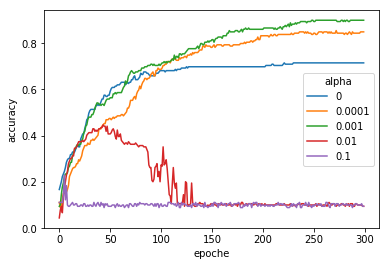

In [228]:
for alpha, trace in zip(alphas, l2_accuracies): 
    plt.plot(trace, label=str(alpha))
plt.legend(title='alpha')
plt.xlabel('epoche')
plt.ylabel('accuracy')
plt.show()

## Dropout

Implement dropout as explained in 7.12. Create a function generateMask(p_input, p_hidden) that generates a list of l arrays, each element in l being an array of size (layer_size, 1). Each element of the array on the first level is 1 with probability p_input. Each element of the array on the last level (output layer) is 1. Each element of the other arrays is 1 with probability p_hidden. For this you can use the distribution scipy.stats.bernoulli. Add hyperparameters p_input and p_hidden to the network. 

Inference occurs as presented in equation 7.52. Plot how the test performance varies for various values of k. 

In [7]:
layers = [num_features, 50, 50, 50, num_classes]

def dropout_test_accuracy(k):
    net = Network(layers)
    sgd_result = net.SGD(train_set, 300,
                         50, 0.1,
                         p_input=0.9, p_hidden=0.8, k=k,
                         validation_data=test_set,
                         monitor_evaluation_accuracy=True)
    t_cost, t_accuracy, e_cost, e_accuracy = sgd_result
    return np.array(e_accuracy) / len(test_set)

ks = (1, 3, 10)
dropout_accuracies = [dropout_test_accuracy(k) for k in ks]

backprop: updating weights: norm of W_1: 49.48036974980975
backprop: updating weights: norm of W_1: 49.48013848021528
backprop: updating weights: norm of W_1: 49.479879317641135
backprop: updating weights: norm of W_1: 49.47963903750655
backprop: updating weights: norm of W_1: 49.47937233383474
backprop: updating weights: norm of W_1: 49.479132006883134
backprop: updating weights: norm of W_1: 49.478866342901256
backprop: updating weights: norm of W_1: 49.47868613405743
backprop: updating weights: norm of W_1: 49.478554729955285
backprop: updating weights: norm of W_1: 49.47834349747677
backprop: updating weights: norm of W_1: 49.478140626400226
backprop: updating weights: norm of W_1: 49.47792105888648
backprop: updating weights: norm of W_1: 49.47778949607418
backprop: updating weights: norm of W_1: 49.47760503096718
backprop: updating weights: norm of W_1: 49.47747090543107
backprop: updating weights: norm of W_1: 49.477345065544384
backprop: updating weights: norm of W_1: 49.477219

backprop: updating weights: norm of W_1: 49.47197646433761
backprop: updating weights: norm of W_1: 49.47198383812916
backprop: updating weights: norm of W_1: 49.471964066756726
backprop: updating weights: norm of W_1: 49.471947991267996
backprop: updating weights: norm of W_1: 49.471938043845945
backprop: updating weights: norm of W_1: 49.47193406388697
Epoch 4 complete
Accuracy on evaluation data: 17 / 179
backprop: updating weights: norm of W_1: 49.47190345267257
backprop: updating weights: norm of W_1: 49.47190380337463
backprop: updating weights: norm of W_1: 49.471853392071026
backprop: updating weights: norm of W_1: 49.47184426823633
backprop: updating weights: norm of W_1: 49.471844102614135
backprop: updating weights: norm of W_1: 49.47180862374258
backprop: updating weights: norm of W_1: 49.471827671032905
backprop: updating weights: norm of W_1: 49.47182761857131
backprop: updating weights: norm of W_1: 49.471809154405946
backprop: updating weights: norm of W_1: 49.471793127

KeyboardInterrupt: 

In [174]:
layers = [num_features, 50, 50, 50, num_classes]

def dropout_test_accuracy(k):
    net = Network(layers)
    sgd_result = net.SGD(train_set, 300,
                         50, 0.1,
                         p_input=0.9, p_hidden=0.8, k=k,
                         validation_data=test_set,
                         monitor_evaluation_accuracy=True)
    t_cost, t_accuracy, e_cost, e_accuracy = sgd_result
    return np.array(e_accuracy) / len(test_set)

ks = (1, 3, 10)
dropout_accuracies = [dropout_test_accuracy(k) for k in ks]


Epoch 0 complete
Accuracy on evaluation data: 21 / 179
Epoch 1 complete
Accuracy on evaluation data: 25 / 179
Epoch 2 complete
Accuracy on evaluation data: 22 / 179
Epoch 3 complete
Accuracy on evaluation data: 18 / 179
Epoch 4 complete
Accuracy on evaluation data: 20 / 179
Epoch 5 complete
Accuracy on evaluation data: 20 / 179
Epoch 6 complete
Accuracy on evaluation data: 21 / 179
Epoch 7 complete
Accuracy on evaluation data: 14 / 179
Epoch 8 complete
Accuracy on evaluation data: 20 / 179
Epoch 9 complete
Accuracy on evaluation data: 23 / 179
Epoch 10 complete
Accuracy on evaluation data: 21 / 179
Epoch 11 complete
Accuracy on evaluation data: 16 / 179
Epoch 12 complete
Accuracy on evaluation data: 25 / 179
Epoch 13 complete
Accuracy on evaluation data: 23 / 179
Epoch 14 complete
Accuracy on evaluation data: 21 / 179
Epoch 15 complete
Accuracy on evaluation data: 21 / 179
Epoch 16 complete
Accuracy on evaluation data: 15 / 179
Epoch 17 complete
Accuracy on evaluation data: 21 / 179
Ep

Epoch 146 complete
Accuracy on evaluation data: 35 / 179
Epoch 147 complete
Accuracy on evaluation data: 32 / 179
Epoch 148 complete
Accuracy on evaluation data: 29 / 179
Epoch 149 complete
Accuracy on evaluation data: 30 / 179
Epoch 150 complete
Accuracy on evaluation data: 41 / 179
Epoch 151 complete
Accuracy on evaluation data: 45 / 179
Epoch 152 complete
Accuracy on evaluation data: 43 / 179
Epoch 153 complete
Accuracy on evaluation data: 39 / 179
Epoch 154 complete
Accuracy on evaluation data: 46 / 179
Epoch 155 complete
Accuracy on evaluation data: 39 / 179
Epoch 156 complete
Accuracy on evaluation data: 40 / 179
Epoch 157 complete
Accuracy on evaluation data: 45 / 179
Epoch 158 complete
Accuracy on evaluation data: 29 / 179
Epoch 159 complete
Accuracy on evaluation data: 48 / 179
Epoch 160 complete
Accuracy on evaluation data: 47 / 179
Epoch 161 complete
Accuracy on evaluation data: 34 / 179
Epoch 162 complete
Accuracy on evaluation data: 46 / 179
Epoch 163 complete
Accuracy on 

Epoch 290 complete
Accuracy on evaluation data: 77 / 179
Epoch 291 complete
Accuracy on evaluation data: 77 / 179
Epoch 292 complete
Accuracy on evaluation data: 95 / 179
Epoch 293 complete
Accuracy on evaluation data: 79 / 179
Epoch 294 complete
Accuracy on evaluation data: 75 / 179
Epoch 295 complete
Accuracy on evaluation data: 79 / 179
Epoch 296 complete
Accuracy on evaluation data: 79 / 179
Epoch 297 complete
Accuracy on evaluation data: 75 / 179
Epoch 298 complete
Accuracy on evaluation data: 84 / 179
Epoch 299 complete
Accuracy on evaluation data: 82 / 179
Epoch 0 complete
Accuracy on evaluation data: 21 / 179
Epoch 1 complete
Accuracy on evaluation data: 22 / 179
Epoch 2 complete
Accuracy on evaluation data: 19 / 179
Epoch 3 complete
Accuracy on evaluation data: 18 / 179
Epoch 4 complete
Accuracy on evaluation data: 23 / 179
Epoch 5 complete
Accuracy on evaluation data: 29 / 179
Epoch 6 complete
Accuracy on evaluation data: 29 / 179
Epoch 7 complete
Accuracy on evaluation data:

Epoch 136 complete
Accuracy on evaluation data: 70 / 179
Epoch 137 complete
Accuracy on evaluation data: 79 / 179
Epoch 138 complete
Accuracy on evaluation data: 66 / 179
Epoch 139 complete
Accuracy on evaluation data: 77 / 179
Epoch 140 complete
Accuracy on evaluation data: 70 / 179
Epoch 141 complete
Accuracy on evaluation data: 74 / 179
Epoch 142 complete
Accuracy on evaluation data: 74 / 179
Epoch 143 complete
Accuracy on evaluation data: 76 / 179
Epoch 144 complete
Accuracy on evaluation data: 67 / 179
Epoch 145 complete
Accuracy on evaluation data: 79 / 179
Epoch 146 complete
Accuracy on evaluation data: 71 / 179
Epoch 147 complete
Accuracy on evaluation data: 79 / 179
Epoch 148 complete
Accuracy on evaluation data: 80 / 179
Epoch 149 complete
Accuracy on evaluation data: 75 / 179
Epoch 150 complete
Accuracy on evaluation data: 72 / 179
Epoch 151 complete
Accuracy on evaluation data: 75 / 179
Epoch 152 complete
Accuracy on evaluation data: 76 / 179
Epoch 153 complete
Accuracy on 

Epoch 279 complete
Accuracy on evaluation data: 111 / 179
Epoch 280 complete
Accuracy on evaluation data: 114 / 179
Epoch 281 complete
Accuracy on evaluation data: 107 / 179
Epoch 282 complete
Accuracy on evaluation data: 107 / 179
Epoch 283 complete
Accuracy on evaluation data: 114 / 179
Epoch 284 complete
Accuracy on evaluation data: 112 / 179
Epoch 285 complete
Accuracy on evaluation data: 109 / 179
Epoch 286 complete
Accuracy on evaluation data: 113 / 179
Epoch 287 complete
Accuracy on evaluation data: 115 / 179
Epoch 288 complete
Accuracy on evaluation data: 108 / 179
Epoch 289 complete
Accuracy on evaluation data: 113 / 179
Epoch 290 complete
Accuracy on evaluation data: 121 / 179
Epoch 291 complete
Accuracy on evaluation data: 113 / 179
Epoch 292 complete
Accuracy on evaluation data: 114 / 179
Epoch 293 complete
Accuracy on evaluation data: 114 / 179
Epoch 294 complete
Accuracy on evaluation data: 115 / 179
Epoch 295 complete
Accuracy on evaluation data: 111 / 179
Epoch 296 comp

Accuracy on evaluation data: 63 / 179
Epoch 125 complete
Accuracy on evaluation data: 66 / 179
Epoch 126 complete
Accuracy on evaluation data: 72 / 179
Epoch 127 complete
Accuracy on evaluation data: 66 / 179
Epoch 128 complete
Accuracy on evaluation data: 67 / 179
Epoch 129 complete
Accuracy on evaluation data: 78 / 179
Epoch 130 complete
Accuracy on evaluation data: 58 / 179
Epoch 131 complete
Accuracy on evaluation data: 76 / 179
Epoch 132 complete
Accuracy on evaluation data: 73 / 179
Epoch 133 complete
Accuracy on evaluation data: 71 / 179
Epoch 134 complete
Accuracy on evaluation data: 75 / 179
Epoch 135 complete
Accuracy on evaluation data: 72 / 179
Epoch 136 complete
Accuracy on evaluation data: 76 / 179
Epoch 137 complete
Accuracy on evaluation data: 74 / 179
Epoch 138 complete
Accuracy on evaluation data: 80 / 179
Epoch 139 complete
Accuracy on evaluation data: 76 / 179
Epoch 140 complete
Accuracy on evaluation data: 70 / 179
Epoch 141 complete
Accuracy on evaluation data: 71

Accuracy on evaluation data: 113 / 179
Epoch 268 complete
Accuracy on evaluation data: 111 / 179
Epoch 269 complete
Accuracy on evaluation data: 108 / 179
Epoch 270 complete
Accuracy on evaluation data: 116 / 179
Epoch 271 complete
Accuracy on evaluation data: 115 / 179
Epoch 272 complete
Accuracy on evaluation data: 112 / 179
Epoch 273 complete
Accuracy on evaluation data: 114 / 179
Epoch 274 complete
Accuracy on evaluation data: 113 / 179
Epoch 275 complete
Accuracy on evaluation data: 115 / 179
Epoch 276 complete
Accuracy on evaluation data: 112 / 179
Epoch 277 complete
Accuracy on evaluation data: 112 / 179
Epoch 278 complete
Accuracy on evaluation data: 111 / 179
Epoch 279 complete
Accuracy on evaluation data: 113 / 179
Epoch 280 complete
Accuracy on evaluation data: 115 / 179
Epoch 281 complete
Accuracy on evaluation data: 114 / 179
Epoch 282 complete
Accuracy on evaluation data: 117 / 179
Epoch 283 complete
Accuracy on evaluation data: 112 / 179
Epoch 284 complete
Accuracy on ev

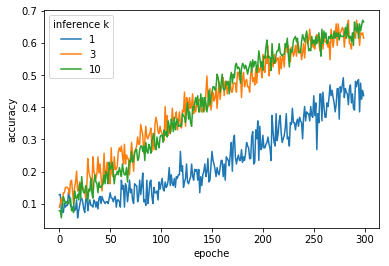

In [175]:
for k, trace in zip(ks, dropout_accuracies): 
    plt.plot(trace, label=str(k))
plt.legend(title='inference k')
plt.xlabel('epoche')
plt.ylabel('accuracy')
plt.show()

## Early stopping

Implement early stopping as presented in algorithm 7.1 and 7.2. Make sure to make proper use of the validation and the test set (as provided above). 

Demonstrate the correct usage by plotting learning curves for train, validation and test performance. 

In [242]:
layers = [num_features, 50, 50, 50, num_classes]

def foo(n, patience):
    net = Network(layers)

    epochs, pretrain_accuracy, prevalid_accuracy = net.SGD_stopping_steps(train_set, n,
                                50, 0.1, patience,
                                validation_data=valid_set)
    
    print("Now train only {} steps".format(epochs))
    net = Network(layers)
    large_train_set = train_set + valid_set
    sgd_result = net.SGD(large_train_set, epochs,
                 50, 0.1, 
         validation_data=test_set,
         monitor_training_accuracy=True,
         monitor_evaluation_accuracy=True)
    return (np.array(pretrain_accuracy)/len(train_set), 
            np.array(prevalid_accuracy)/len(valid_set), 
            np.array(sgd_result[1])/len(large_train_set), 
            np.array(sgd_result[3])/len(test_set),
            epochs)

pre_train_accuracy, pre_valid_accuracy, train_accuracy, test_accuracy, stopping_steps = foo(3, 5)

Epoch 0 complete
Accuracy on training data: 143 / 1438
Accuracy on evaluation data: 17 / 180
Epoch 1 complete
Accuracy on training data: 143 / 1438
Accuracy on evaluation data: 17 / 180
Epoch 2 complete
Accuracy on training data: 143 / 1438
Accuracy on evaluation data: 16 / 180
Epoch 0 complete
Accuracy on training data: 323 / 1438
Accuracy on evaluation data: 36 / 180
Epoch 1 complete
Accuracy on training data: 368 / 1438
Accuracy on evaluation data: 41 / 180
Epoch 2 complete
Accuracy on training data: 393 / 1438
Accuracy on evaluation data: 41 / 180
Epoch 0 complete
Accuracy on training data: 423 / 1438
Accuracy on evaluation data: 44 / 180
Epoch 1 complete
Accuracy on training data: 446 / 1438
Accuracy on evaluation data: 43 / 180
Epoch 2 complete
Accuracy on training data: 462 / 1438
Accuracy on evaluation data: 48 / 180
Epoch 0 complete
Accuracy on training data: 474 / 1438
Accuracy on evaluation data: 50 / 180
Epoch 1 complete
Accuracy on training data: 486 / 1438
Accuracy on eva

Epoch 1 complete
Accuracy on training data: 1159 / 1438
Accuracy on evaluation data: 122 / 180
Epoch 2 complete
Accuracy on training data: 1164 / 1438
Accuracy on evaluation data: 121 / 180
Epoch 0 complete
Accuracy on training data: 1169 / 1438
Accuracy on evaluation data: 121 / 180
Epoch 1 complete
Accuracy on training data: 1178 / 1438
Accuracy on evaluation data: 121 / 180
Epoch 2 complete
Accuracy on training data: 1182 / 1438
Accuracy on evaluation data: 122 / 180
Epoch 0 complete
Accuracy on training data: 1182 / 1438
Accuracy on evaluation data: 121 / 180
Epoch 1 complete
Accuracy on training data: 1187 / 1438
Accuracy on evaluation data: 123 / 180
Epoch 2 complete
Accuracy on training data: 1193 / 1438
Accuracy on evaluation data: 123 / 180
Epoch 0 complete
Accuracy on training data: 1199 / 1438
Accuracy on evaluation data: 123 / 180
Epoch 1 complete
Accuracy on training data: 1194 / 1438
Accuracy on evaluation data: 123 / 180
Epoch 2 complete
Accuracy on training data: 1200 /

Epoch 43 complete
Accuracy on training data: 950 / 1618
Accuracy on evaluation data: 92 / 179
Epoch 44 complete
Accuracy on training data: 959 / 1618
Accuracy on evaluation data: 93 / 179
Epoch 45 complete
Accuracy on training data: 965 / 1618
Accuracy on evaluation data: 95 / 179
Epoch 46 complete
Accuracy on training data: 973 / 1618
Accuracy on evaluation data: 95 / 179
Epoch 47 complete
Accuracy on training data: 982 / 1618
Accuracy on evaluation data: 95 / 179
Epoch 48 complete
Accuracy on training data: 983 / 1618
Accuracy on evaluation data: 94 / 179
Epoch 49 complete
Accuracy on training data: 998 / 1618
Accuracy on evaluation data: 93 / 179
Epoch 50 complete
Accuracy on training data: 1014 / 1618
Accuracy on evaluation data: 94 / 179
Epoch 51 complete
Accuracy on training data: 1025 / 1618
Accuracy on evaluation data: 96 / 179
Epoch 52 complete
Accuracy on training data: 1026 / 1618
Accuracy on evaluation data: 97 / 179
Epoch 53 complete
Accuracy on training data: 1037 / 1618


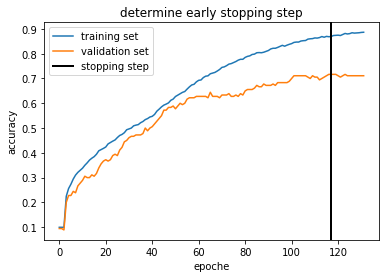

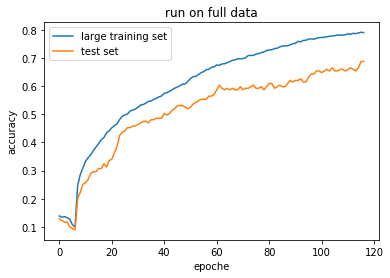

In [251]:
plt.plot(pre_train_accuracy, label='training set')
plt.plot(pre_valid_accuracy, label='validation set')
plt.axvline(x=stopping_steps, linewidth=2, color='k', label='stopping step')
plt.title('determine early stopping step')
plt.legend()
plt.xlabel('epoche')
plt.ylabel('accuracy')
plt.show()

plt.plot(train_accuracy, label='large training set')
plt.plot(test_accuracy, label='test set')
plt.title('run on full data')
plt.legend()
plt.xlabel('epoche')
plt.ylabel('accuracy')
plt.show()

In [244]:
max_i = np.argmax(pre_valid_accuracy)
for i, v in enumerate(pre_valid_accuracy):
    x = ""
    if i == max_i:
        x = "IS MAX"
    print("{}. {} {}".format(i,v, x))

0. 0.09444444444444444 
1. 0.09444444444444444 
2. 0.08888888888888889 
3. 0.2 
4. 0.22777777777777777 
5. 0.22777777777777777 
6. 0.24444444444444444 
7. 0.2388888888888889 
8. 0.26666666666666666 
9. 0.2777777777777778 
10. 0.28888888888888886 
11. 0.3055555555555556 
12. 0.3 
13. 0.3 
14. 0.3111111111111111 
15. 0.3055555555555556 
16. 0.31666666666666665 
17. 0.3388888888888889 
18. 0.35555555555555557 
19. 0.36666666666666664 
20. 0.37222222222222223 
21. 0.36666666666666664 
22. 0.37222222222222223 
23. 0.3888888888888889 
24. 0.39444444444444443 
25. 0.3888888888888889 
26. 0.4111111111111111 
27. 0.4222222222222222 
28. 0.4444444444444444 
29. 0.45 
30. 0.46111111111111114 
31. 0.4666666666666667 
32. 0.4666666666666667 
33. 0.4722222222222222 
34. 0.4722222222222222 
35. 0.4722222222222222 
36. 0.4777777777777778 
37. 0.5 
38. 0.4888888888888889 
39. 0.5 
40. 0.5055555555555555 
41. 0.5166666666666667 
42. 0.5277777777777778 
43. 0.5388888888888889 
44. 0.55 
45. 0.57222222222

## Evaluation

- not very
- quite
- very

5h